### Import Pandas, Numpy

In [1]:
import pandas as pd
import numpy as np

In [2]:
# show all columns and rows in dataframes
pd.options.display.max_columns = None
pd.options.display.max_rows = None

### Classes For The Datasets

In [3]:
# import IterativeImputer class for imputing missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# combines data from all counties regarding personnel associated with judicial system
class CourtPersonnel:
    
    # reads in excel file containing personnel data
    def __init__(self, excel_file):
        self.df = pd.read_excel(excel_file)
    
    # converts the 'Public Defenders' column to binary
    def pdef_binary_transform(self):
        self.df['Public Defenders'] = self.df['Public Defenders'].apply(lambda x: 1 if x != 0 else 0)

        return self.df
    
    # cleans the personnel dataset by converting and renaming columns, thus returning dataframe
    def ct_personnel_clean(self):
        new_columns = {'County': 'county', 'District Judges/Magistrates': 'dist_judg_mag',
                       'Assistant/Deputy Clerks': 'clerks', 'District Attorneys': 'dist_attys',
                       'Public Defenders': 'p_def',
                       'Law Enforcement Agencies': 'law_enf_ag'}
        self.pdef_binary_transform()
        self.df = self.df.rename(columns=new_columns)
        self.df.iloc[:, -1] = self.df.iloc[:, -1].astype('int64')

        return self.df
    

# combines population for all years into dataframe
class CountyPop:
    
    # reads in excel file for population
    def __init__(self, excel_file):
        self.file = excel_file
        self.df = None
    
    # removes unnecessary columns and rows 
    def slice_df(self):
        self.df = pd.read_excel(self.file).iloc[3:-2, 3:10]
        
        return self.df
    
    # converts all columns to integer data type
    def change_dtypes(self):
        for col in list(self.df.columns.values):
            self.df[col] = self.df[col].astype('int64')
        
        return self.df
    
    # cleans dataset and renames dataframe
    def county_pop_clean(self):
        self.slice_df()
        self.change_dtypes()
        
        return self.df.mean(axis=1).astype('int64').to_frame().reset_index(drop=True).rename(columns={0: 'avg_pop'})
    

# combines all median income data and returns a dataframe with the average
class AvgIncome:

    # reads in csv file for median income
    def __init__(self, csv_file):

        self.df = pd.read_csv(csv_file)
    
    # computes the average of all median incomes and converts column to integer data type
    def clean_avg_income(self):

        self.df = self.df.mean(axis=1).to_frame().rename(columns={0: 'avg_income'})
        self.df['avg_income'] = self.df['avg_income'].astype('int64')

        return self.df
    
# combines violent crime data and returns single column of averages
class ViolentCrimeData:
    
    # reads in a list of excel files
    def __init__(self, a_list):
        self.file_list = a_list
        self.file_dict = {}
        self.years = None
        self.files = None
        self.df = None
        self.concat_df = None
    
    # creates dictionary of files from init method with years as keys and file names as values
    def create_file_dict(self):
        for file in self.file_list:
            self.file_dict[int(file[:4])] = file

        return self.file_dict
    
    # concatenates all files in dictionary and returns dataframe 
    def concat_h(self):
        self.years = list(self.file_dict.keys())
        self.files = list(self.file_dict.values())
        self.df = pd.read_excel(self.files[0])
        self.df = self.split_df()
        for i in range(1, len(self.files)):
            self.concat_df = pd.read_excel(self.files[i])
            self.concat_df = self.split_concat_df()
            self.df = pd.concat([self.df, self.concat_df], axis=1)

        return self.df
    
    # slices the column with violent crime rate for self.df
    def split_df(self):
        return self.df.iloc[:, -1].to_frame().reset_index(drop=True)
    
    # slices the column with violent crime rate for self.concat_df
    def split_concat_df(self):
        return self.concat_df.iloc[:, -1].to_frame().reset_index(drop=True)
    
    # imputes any missing values using the Iterative Imputer class
    def iter_imputer(self):
        self.df = self.df.replace(to_replace='unknown', value=np.nan)
        imp = IterativeImputer()
        imp.fit(self.df)
        imp_array = imp.transform(self.df)
        self.df = pd.DataFrame(data=imp_array)

        return self.df
    
    # uses methods to clean all files, concatenate, fill null values, and rename dataframe
    def vcr_load_clean(self):
        self.create_file_dict()
        self.concat_h()
        self.iter_imputer()

        self.df = self.df.mean(axis=1).to_frame().reset_index(drop=True)

        return self.df.rename(columns={0: 'vcr_per_100000'}).round(1)
    

# combines divorce data and returns average
# inherits ViolentCrimeData class due to synonymous calculations
class AvgDivorces(ViolentCrimeData):
    
    # initializes using list of excel files
    def __init__(self, a_list):
        super().__init__(a_list)
    
    # concatenates all divorce datasets and returns averages in a dataframe
    def avgdiv_load_clean(self):
        self.create_file_dict()
        self.concat_h()
        self.df = self.df.mean(axis=1).to_frame().reset_index(drop=True)

        return self.df.rename(columns={0: 'avg_num_divrs'}).round(1)

#combines all opioid overdose deaths and returns dataframe
class OpioidDeaths:

    # reads in csv file containing deaths by overdose in opioids
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)

    # returns one-column dataframe with combined deaths by county and drops all columns with 'NaN' values
    def load_and_clean_data(self):
        self.df = self.df[['Year', 'County', 'Drug', 'Count']].dropna().sort_values(by=['Year', 'County'],
                                                                                    ascending=True)
        self.df = self.df[(self.df['Drug'] == 'Any Opioid') & (self.df['Year'] >= 2012)].groupby(['County'])[
            'Count'].sum().to_frame().reset_index().rename(columns={'Count':'op_od_deaths'})

        return self.df.iloc[:,-1].to_frame().reset_index(drop=True)
    
# converts case inventory dataset into a column of computed ratios
class CaseDisposition:
    
    # reads in csv file for case inventory
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file, delimiter=';')
    
    # extracts columns with felony superior court cases
    def fel_sup_group(self):
        fel_bool = self.df['Case_Type'] == 'Felonies'
        sup_bool = self.df['File_Type'] == 'CRS'
        self.df = self.df[fel_bool & sup_bool].reset_index()
        self.df = self.df.groupby(['County', 'Case Status'])['Number_of_Cases'].sum().reset_index()

        return self.df
    
    # computes ratio of disposed cases to pending cases
    def sep_cases(self):
        disp_cases = self.df[self.df['Case Status'] == 'Disposed'].iloc[:, -1].astype(float).to_frame().reset_index(
            drop=True)
        pending = self.df[self.df['Case Status'] == 'End Pending'].iloc[:, -1].astype(float).to_frame().reset_index(
            drop=True)
        return disp_cases / pending
    
    # returns dataframe with case disposition ratio rounded to 3 decimal places and renamed column
    def load_clean_cases(self):
        self.df = self.fel_sup_group()

        return self.sep_cases().rename(columns={'Number_of_Cases': 'case_disp_ratio'}).round(3)

### Combining Datasets 

We will use all of these classes for building the preprocessed data set for the model using another class called *CombineAllData*.

In [4]:
# combines all features for case disposition inefficiency model
class CombineAllData:

    def __init__(self):
        # assign names to all needed files
        self.ct_personnel_file = 'nc_court_data_by_county.xlsx'
        self.population_file = 'county_pop.xlsx'
        self.income_file = 'nc_median_income_by_county.csv'
        self.divrs_files = ['2012 Divorce Rate By County.xlsx', '2013 Divorce Rate By County.xlsx',
                            '2014 Divorce Rate By County.xlsx', '2015 Divorce Rate By County.xlsx',
                            '2016 Divorce Rate By County.xlsx', '2017 Divorce Rate By County.xlsx',
                            '2018 Divorce Rate By County.xlsx']
        self.vcr_files = ['2012 Violent Crimes By County.xlsx', '2013 Violent Crimes By County.xlsx',
                          '2014 Violent Crimes By County.xlsx', '2015 Violent Crimes By County.xlsx',
                          '2016 Violent Crimes By County.xlsx', '2017 Violent Crimes By County.xlsx',
                          '2018 Violent Crimes By County.xlsx']
        self.opioid_deaths_file = 'od_deaths.csv'
        self.case_disp_file = 'caseload_inventory.csv'
        self.preprocessing_df = None
    
    # creates dataframes from loaded files using classes
    def load_all_data(self):
        self.personnel_df = CourtPersonnel(self.ct_personnel_file).ct_personnel_clean()
        self.population_df = CountyPop(self.population_file).county_pop_clean()
        self.income_df = AvgIncome(self.income_file).clean_avg_income()
        self.avg_divr_df = AvgDivorces(self.divrs_files).avgdiv_load_clean()
        self.vcr_df = ViolentCrimeData(self.vcr_files).vcr_load_clean()
        self.opioid_df = OpioidDeaths(self.opioid_deaths_file).load_and_clean_data()
        self.case_disp_df = CaseDisposition(self.case_disp_file).load_clean_cases()

        return self
    
    # saves preprocessed data in a csv file to be used for model
    def create_preprocess_save(self):
        concat_list = [self.personnel_df, self.population_df, self.income_df,
                       self.avg_divr_df, self.vcr_df, self.opioid_df, self.case_disp_df]
        self.preprocessing_df = pd.concat(concat_list, axis=1)

        return self.preprocessing_df.to_csv('courts_preprocessing_df.csv', index=False)

## Preprocessing for Machine Learning Model

Now that I have the CombineAllData class, I can use it to create the dataframe that includes all of the features for the preprocessing stage of creating the machine learning model and will highlight the important features.  Lastly, the model will determine whether a county may be in need of further resources to boost case disposition ratio for improved efficiency.  Building the classes in the previous cells allows for me to generate the preprocessing csv file in just a few lines of code.

In [5]:
combine = CombineAllData()
combine.load_all_data().create_preprocess_save()

Let's take a look at the first few rows of the data to view the features.

In [6]:
preprocessing_df = pd.read_csv('courts_preprocessing_df.csv')
preprocessing_df.head()

,county,dist_judg_mag,clerks,dist_attys,p_def,law_enf_ag,avg_pop,avg_income,avg_num_divrs,vcr_per_100000,op_od_deaths,case_disp_ratio
0,Alamance,15,34,8,0,7,158137,51303,510.7,422.2,773,1.951
1,Alexander,4,10,0,0,2,37737,49864,88.4,176.8,225,1.436
2,Alleghany,3,6,2,0,3,11224,40420,48.3,185.8,53,1.744
3,Anson,4,8,2,0,4,25949,39278,68.7,511.0,87,1.950
4,Ashe,2,7,0,0,6,27212,46667,93.9,108.2,135,1.377


### Building the Model Using a Class

The overall goal is to detect any counties in North Carolina likely in need of additional resources to improve case disposition efficiency such as possible increased funding for hiring more law enforcement or creating district court judge and magistrate seats. This class will perform the following functions:

1. Read in the preprocessed data as a csv file.
2. Sets up the unscaled features and target data.
3. Creates dataframe for selected scaled features using the CustomScaler class.
4. Runs a logistic regression model based on the scaled data.
5. Creates a summary table displaying the coefficients for all features.
6. Saves the model (when applicable).
7. Connects to MySQL and creates database with predictions and summary table along with storing the results

### Custom Scaler Class

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler


# create the Custom Scaler class

class CustomScaler(BaseEstimator, TransformerMixin):

    # init or what information we need to declare a CustomScaler object
    # and what is calculated/declared as we do

    def __init__(self, columns, copy=True, with_mean=True, with_std=True):
        # scaler is nothing but a StandardScaler object
        self.scaler = StandardScaler(copy, with_mean, with_std)
        # with some columns
        self.columns = columns
        self.mean_ = None
        self.var_ = None

    # the fit method, which, again based on StandardScaler

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        self.mean_ = np.mean(X[self.columns])
        self.var_ = np.var(X[self.columns])
        return self

    # the transform method which does the actual scaling

    def transform(self, X, y=None, copy=None):
        # record the initial order of the columns
        init_col_order = X.columns

        # scale all features that you chose when creating the instance of the class
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)

        # declare a variable containing all information that was not scaled
        X_not_scaled = X.loc[:, ~X.columns.isin(self.columns)]

        # return a data frame which contains all scaled features and all 'not scaled' features
        # use the original order (that you recorded in the beginning)
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

### Model Class for Case Disposition Inefficiency

In [8]:
# import all necessary packages

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import pymysql

# model class that reads in a csv file providing features and targets
class PredictCaseDispIneff:

    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.model_file = None
        self.scaler_file = None
        self.df_preprocessed = None

    # separates unscaled inputs and targets into dataframe and array, respectively
    def load_and_add_targets(self):
        df = pd.read_csv(self.csv_file)
        self.df_preprocessed = df.copy()
        # use median to separate targets for 50/50 split of data
        self.inefficiency_cutoff = df['case_disp_ratio'].median()
        self.targets = np.where(df['case_disp_ratio'] < self.inefficiency_cutoff, 1, 0)
        self.unscaled_inputs = df.iloc[:, 1:-1]

        return self

    # creates inputs for scaling and returns dataframe
    def create_scaled_inputs(self):
        df_columns = list(self.unscaled_inputs.columns.values)
        columns_to_omit = ['p_def']
        columns_to_scale = [col for col in df_columns if col not in columns_to_omit]
        # use CustomScaler class to only scale selected columns
        self.scaled_inputs = CustomScaler(columns_to_scale).fit(self.unscaled_inputs).transform(self.unscaled_inputs)

        return self

    # initializes training model for scaled data using logistic regression
    def init_train_model(self):

        # create instance of model
        self.log_model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                            intercept_scaling=1, l1_ratio=None, max_iter=500,
                                            multi_class='auto', n_jobs=None, penalty='l2',
                                            random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                                            warm_start=False)

        # split up training and testing data using train_test_split with random state of best accuracy
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.scaled_inputs,
                                                                                self.targets, train_size=0.75,
                                                                                random_state=341)

        self.log_model.fit(self.X_train, self.y_train)
        # gives user ability to call training accuracy
        self.log_model_train_score = self.log_model.score(self.X_train, self.y_train)
        # gives user ability to call test accuracy
        self.log_model_test_score = self.log_model.score(self.X_test, self.y_test)
        # assigns model intercept
        self.log_model_intercept = self.log_model.intercept_
        # assigns model coefficients
        self.log_model_coef = self.log_model.coef_

        return self


    def create_summary_table(self):

        feature_name = self.unscaled_inputs.columns.values
        self.summary_table = pd.DataFrame(columns=['feature_name'], data=feature_name)
        self.summary_table['coefficient'] = np.transpose(self.log_model_coef)
        self.summary_table['odds_ratio'] = np.exp(self.summary_table.coefficient)
        self.summary_table = self.summary_table.sort_values('odds_ratio', ascending=False)

        return self

    def st_into_mysql(self):
        # creates variable for insert query to be applied to "predicted_outputs" database in MySQL
        self.st_insert_query = 'INSERT INTO summary_table VALUES '

        # initiates loops as the number of rows in self.summary_table
        for i in range(self.summary_table.shape[0]):
            self.st_insert_query += '('
            # loops over each columns per row
            for j in range(self.summary_table.shape[1]):
                # wraps name of feature in single quotation marks for MySQL
                if j == 0:

                    self.st_insert_query += '\'' + str(self.summary_table[self.summary_table.columns.values[j]][i]) + \
                                         '\'' + ','
                else:
                    self.st_insert_query += str(self.summary_table[self.summary_table.columns.values[j]][i]) + ','
            # ends each row with closing parentheses
            self.st_insert_query = self.st_insert_query[:-1] + '), '
        #
        self.st_insert_query = self.st_insert_query[:-2] + ';'

        # set up **kwargs to create MySQL database connection
        sql_creds = {'database':'predictions', 'user':'root', 'password':'pass_word'}
        # establish connection using pymysql module
        conn = pymysql.connect(**sql_creds)
        # creates cursor for access to the database
        cursor = conn.cursor()
        # executes insert query for summary table
        cursor.execute(self.st_insert_query)
        # saves database
        conn.commit()
        # closes connection
        conn.close()
        return self

    # runs model and returns all functions and their attributes
    def run_model(self):

        self.load_and_add_targets().create_scaled_inputs().init_train_model().create_summary_table()

        return self

    # saves model and scaler (if applicable) using pickle module
    def save_model(self):
        with open('jud_model', 'wb') as file:
            pickle.dump(self.model_file, file)
        with open('jud_scaler', 'wb') as file:
            pickle.dump(self.scaler_file, file)

        return self

    # same as run model function but creates dataframe with all features with probability and prediction as two
    # additional columns from model test results
    def run_and_predict_results(self):

        self.run_model()
        self.df_preprocessed['probability'] = self.log_model.predict_proba(self.scaled_inputs)[:, 1]
        self.df_preprocessed['prediction'] = self.log_model.predict(self.scaled_inputs)

        return self

    # saves resultant dataframe from model in MySQL database for storage and management
    def insert_into_mysql(self):
        # creates variable for insert query to be applied to "predicted_outputs" database in MySQL
        self.insert_query = 'INSERT INTO predicted_outputs VALUES '

        # initiates loops as the number of rows in self.df_preprocessed
        for i in range(self.df_preprocessed.shape[0]):
            self.insert_query += '('
            # loops over each columns per row
            for j in range(self.df_preprocessed.shape[1]):
                # wraps name of county in single quotation marks for MySQL
                if j == 0:

                    self.insert_query += '\'' + str(self.df_preprocessed[self.df_preprocessed.columns.values[j]][i]) + \
                                         '\'' + ','
                else:
                    self.insert_query += str(self.df_preprocessed[self.df_preprocessed.columns.values[j]][i]) + ','
            # ends each row with closing parentheses
            self.insert_query = self.insert_query[:-1] + '), '
        # ends query with semi-colon
        self.insert_query = self.insert_query[:-2] + ';'

        # set up **kwargs to create MySQL database connection
        sql_creds = {'database':'predictions', 'user':'root', 'password':'pass_word'}
        # establish connection using pymysql module
        conn = pymysql.connect(**sql_creds)
        # creates cursor for access to the database
        cursor = conn.cursor()
        # executes insert query for predictions
        cursor.execute(self.insert_query)
        # saves database
        conn.commit()
        # closes connection
        conn.close()

        return self

### Initialze the Model

In [9]:
# import preprocessed data into model class
county_predict = PredictCaseDispIneff('courts_preprocessing_df.csv')

The target data is determined by all case disposition ratios less than the median.  This approach allows 50% of the data to be represented on each side of the middle value along with maintaining an implicitly balanced train/test dataset.  

### Unscaled Inputs and Targets

In [10]:
# creates unscaled inputs as dataframe and targets as numpy array
county_predict.load_and_add_targets()
# median value for target data
print("median:", round(county_predict.load_and_add_targets().inefficiency_cutoff, 3))
print()
print(county_predict.load_and_add_targets().unscaled_inputs.head())
print()
print(county_predict.load_and_add_targets().targets)

median: 1.501

   dist_judg_mag  clerks  dist_attys  p_def  law_enf_ag  avg_pop  avg_income  \
0             15      34           8      0           7   158137       51303   
1              4      10           0      0           2    37737       49864   
2              3       6           2      0           3    11224       40420   
3              4       8           2      0           4    25949       39278   
4              2       7           0      0           6    27212       46667   

   avg_num_divrs  vcr_per_100000  op_od_deaths  
0          510.7           422.2           773  
1           88.4           176.8           225  
2           48.3           185.8            53  
3           68.7           511.0            87  
4           93.9           108.2           135  

[0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1
 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 1 0 1 0 0
 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0]


### Scaled Inputs

In [11]:
# creates scaled inputs dataframe
county_predict.create_scaled_inputs()
# view scaled inputs at a glance
county_predict.create_scaled_inputs().scaled_inputs.head(20)

,dist_judg_mag,clerks,dist_attys,p_def,law_enf_ag,avg_pop,avg_income,avg_num_divrs,vcr_per_100000,op_od_deaths
0,0.782605,0.414820,0.265989,0,0.036009,0.368872,-0.013650,0.328442,0.877084,0.365730
1,-0.556222,-0.507857,-0.659191,0,-0.964239,-0.402176,-0.175133,-0.445235,-0.665409,-0.437234
2,-0.677933,-0.661636,-0.427896,0,-0.764190,-0.571966,-1.234926,-0.518700,-0.608838,-0.689260
3,-0.556222,-0.584747,-0.427896,0,-0.564140,-0.477667,-1.363080,-0.481326,1.435247,-0.639441
4,-0.799645,-0.623192,-0.659191,0,-0.164041,-0.469578,-0.533896,-0.435159,-1.096603,-0.569108
5,-0.677933,-0.700081,-0.427896,0,0.036009,-0.529334,-0.467575,-0.521082,-0.979062,-0.633580
6,-0.312799,-0.277188,0.150342,1,0.436108,-0.339141,-0.125420,-0.272106,0.154237,-0.334666
7,-0.799645,-0.623192,-0.659191,0,-0.364090,-0.514682,-1.234028,-0.525296,-0.772264,-0.683399
8,-0.312799,-0.430967,-0.427896,0,0.036009,-0.420773,-1.046735,-0.459342,-0.361185,-0.498775
9,-0.312799,0.299486,0.497284,0,1.436356,0.148060,0.763015,-0.062885,-0.791750,0.285140


### Train and Run Model

In [12]:
# runs model 
county_predict.run_and_predict_results()
print('Train Score:', county_predict.run_and_predict_results().log_model_train_score)

Train Score: 0.72


### Summary Table

In [13]:
# view summary table with coefficients and odds ratios

county_predict.run_and_predict_results().summary_table

,feature_name,coefficient,odds_ratio
3,p_def,0.566896,1.762788
0,dist_judg_mag,0.465631,1.593020
9,op_od_deaths,0.345726,1.413015
4,law_enf_ag,0.334558,1.397323
2,dist_attys,-0.139540,0.869758
8,vcr_per_100000,-0.222799,0.800275
6,avg_income,-0.282070,0.754221
5,avg_pop,-0.481183,0.618052
1,clerks,-0.637300,0.528718
7,avg_num_divrs,-0.671237,0.511076


According to the model, public defenders, number of district court judges and magistrates, number of opioid overdose deaths, and number of law enforcement agencies are important features affecting case disposition inefficiency for each county since each of the odd ratios is greater than 1.

### Model Predictions

In [14]:
# use log model to predict the targets and model test accuracy
x_test = county_predict.run_and_predict_results().X_test
# print a few rows of the predicted ouptuts dataframe
print(county_predict.run_and_predict_results().df_preprocessed.tail(20), '\n')
print("Test Score:", county_predict.run_and_predict_results().log_model_test_score)

          county  dist_judg_mag  clerks  dist_attys  p_def  law_enf_ag  \
80    Rutherford              8      20           4      1           6   
81       Sampson              5      20           7      0           5   
82      Scotland              4      14           3      1           3   
83        Stanly              6      16           5      0           9   
84        Stokes              4      12           2      0           5   
85         Surry              6      20           6      0           6   
86         Swain              3       5           0      0           3   
87  Transylvania              4       9           2      1           3   
88       Tyrrell              3       5           1      1           1   
89         Union              9      41          12      0           8   
90         Vance              9      13           2      0           4   
91          Wake             42     132          37      1          32   
92        Warren              4       

### Store Predictions and Summary Table in MySQL

In [15]:
# use method to initialize connection to MySQL, connect to database with login credentials, inserts all rows of df_preprocessed, and saves database
county_predict.insert_into_mysql()
county_predict.st_into_mysql()

### Verify Stored Database and Tables in MySQL

In [16]:
# create dicitionary to use **kwargs for the connection
sql_creds = {'database':'predictions', 'user':'root', 'password':'pass_word'}
# establish connection using pymysql module
conn = pymysql.connect(**sql_creds)
# create cursor for connection
cursor = conn.cursor()
# create queries to print all rows of predicted outputs table and summary table in MySQL
pred_query = "SELECT * FROM predicted_outputs;"
# lists summary table in order of greatest to least odds ratios for the features
st_query = "SELECT * FROM summary_table ORDER BY odds_ratio DESC;"

#### Predictions

In [17]:
# execute predictions query
cursor.execute(pred_query)
# assign variable to all rows
predictions = cursor.fetchall()
# print a few rows of the predictions table
for row in predictions[:10]:
    print(row)

# prints new line
print()
# compare this to df_preprocessed in model class
predictions_df = county_predict.df_preprocessed
print(predictions_df.head(10))

('Alamance', 15, 34, 8, 0, 7, 158137, 51303, 510.7, 422.2, 773, 1.951, 0.332811, 0)
('Alexander', 4, 10, 0, 0, 2, 37737, 49864, 88.4, 176.8, 225, 1.436, 0.516376, 1)
('Alleghany', 3, 6, 2, 0, 3, 11224, 40420, 48.3, 185.8, 53, 1.744, 0.615792, 1)
('Anson', 4, 8, 2, 0, 4, 25949, 39278, 68.7, 511.0, 87, 1.95, 0.518445, 1)
('Ashe', 2, 7, 0, 0, 6, 27212, 46667, 93.9, 108.2, 135, 1.377, 0.615559, 1)
('Avery', 3, 5, 2, 0, 7, 17881, 47258, 47.0, 126.9, 91, 2.021, 0.65256, 1)
('Beaufort', 6, 16, 7, 1, 9, 47580, 50307, 182.9, 307.2, 295, 1.159, 0.656239, 1)
('Bertie', 2, 7, 0, 0, 5, 20169, 40428, 44.7, 159.8, 57, 0.786, 0.639162, 1)
('Bladen', 6, 12, 2, 0, 7, 34833, 42097, 80.7, 225.2, 183, 1.399, 0.647359, 1)
('Brunswick', 6, 31, 10, 0, 14, 123657, 58224, 297.1, 156.7, 718, 1.591, 0.449665, 0)

      county  dist_judg_mag  clerks  dist_attys  p_def  law_enf_ag  avg_pop  \
0   Alamance             15      34           8      0           7   158137   
1  Alexander              4      10          

#### Summary Table

In [18]:
# execute summary_table query
cursor.execute(st_query)
# assign variable to all rows
summary_table = cursor.fetchall()
# print a few rows of the summary_table database table
for row in summary_table:
    print(row)
    
# prints new line
print()
# compare this to summary_table within the model class
summary_table_df = county_predict.summary_table
print(summary_table_df)

('p_def', 0.566896, 1.76279)
('dist_judg_mag', 0.465631, 1.59302)
('op_od_deaths', 0.345726, 1.41302)
('law_enf_ag', 0.334558, 1.39732)
('dist_attys', -0.13954, 0.869758)
('vcr_per_100000', -0.222799, 0.800275)
('avg_income', -0.28207, 0.754221)
('avg_pop', -0.481183, 0.618052)
('clerks', -0.6373, 0.528718)
('avg_num_divrs', -0.671237, 0.511076)

     feature_name  coefficient  odds_ratio
3           p_def     0.566896    1.762788
0   dist_judg_mag     0.465631    1.593020
9    op_od_deaths     0.345726    1.413015
4      law_enf_ag     0.334558    1.397323
2      dist_attys    -0.139540    0.869758
8  vcr_per_100000    -0.222799    0.800275
6      avg_income    -0.282070    0.754221
5         avg_pop    -0.481183    0.618052
1          clerks    -0.637300    0.528718
7   avg_num_divrs    -0.671237    0.511076


In [19]:
# close connection
conn.close()

### Key Highlights Based on Model with Tableau Visualization Images

In [20]:
# import Image module from IPython
from IPython.display import Image

#### Target County Statistics

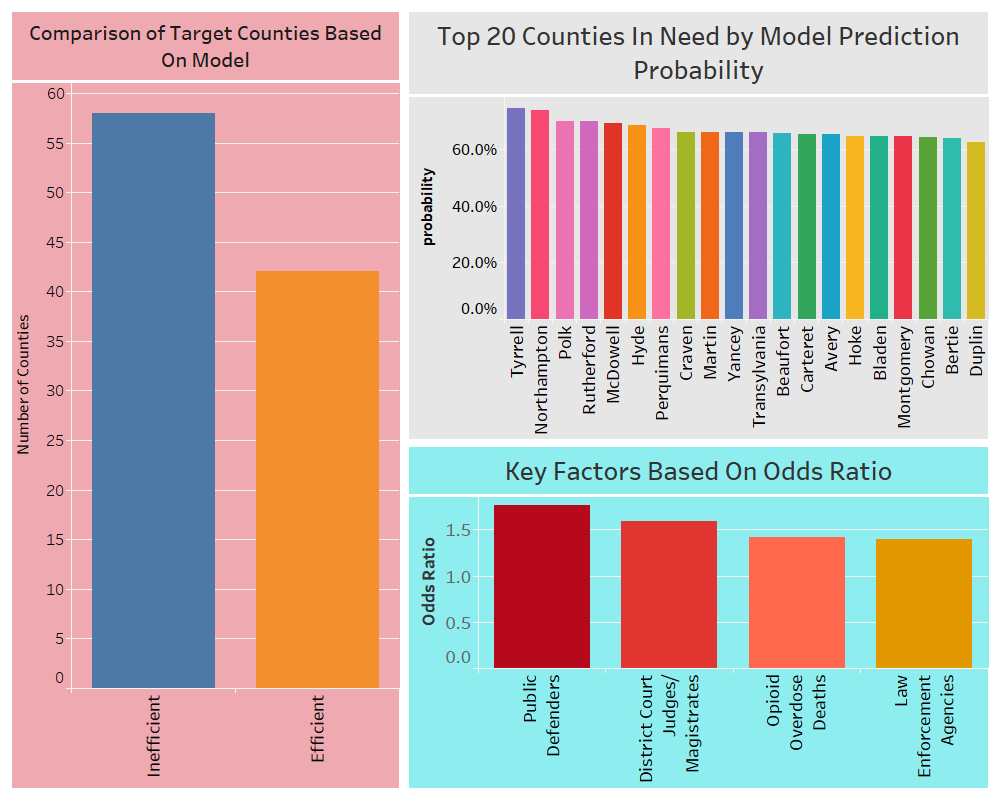

In [21]:
# insert image path
Image('C:\\Users\\pytho\\Desktop\\Judicial Staff ML Project\\datasets\\Target Counties Stats.png')

#### Case Disposition Ratio by Geographic Location

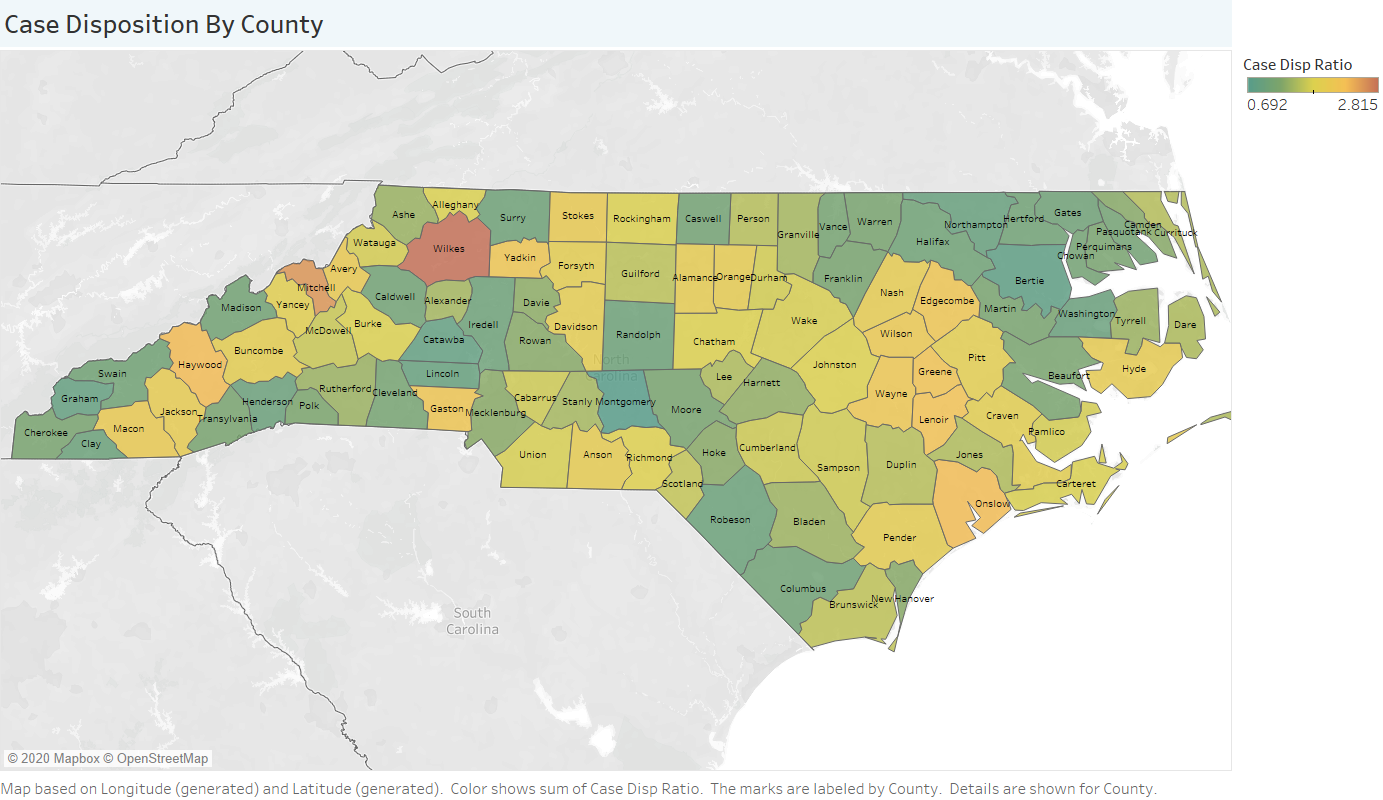

In [22]:
# insert image path
Image('C:\\Users\\pytho\\Desktop\\Judicial Staff ML Project\\datasets\\Case Disp By County.png')

### Findings

The model predicted 58 counties to be inefficient when disposing of felony cases, which accounts for approximately 60% of all counties in North Carolina.  Tyrrell, Northampton, and Polk are among the top three counties needing additional resources, according to the probability of the model. The accuracy of the model's test score is 16% less than the training score.  This may have occurred as a result of model overfitting with regards to a random_state=341, used ONLY for obtaining highest model accuracy.  However, the model detected several features that could be determining factors of case disposition efficiency within a county.  Whether a county would have at least one public defender has the greatest weight in the summary table.  Anyone charged with a crime, felony in this case, who is at risk of jail confinement and cannot afford an attorney is appointed a public defender.  Counties without public defender offices are likely to face adversity in disposing felony cases, especially poverty-stricken areas.  The number of district court judges and magistrates rank second in weight of the model.  Counties well equipped with a sufficient number of district court judges and magistrates are likely more prepared to dispose district cases indicted to superior court.  The number of opioid overdose deaths is the next most important feature and could suggest that the astronomical increase in opioid abuse calls for increased felony criminal activity resulting in more filed cases.  Lastly, the number of law enforcement agencies carries significant weight in the model.  A reasonable explanation is the theory that a shortage in law enforcement agencies within a county implicates backlog for pending cases.  An increase in caseload for law enforcement causes stagnancy in personnel who interact with NC's case maintenance.  One final note on this project is the possibility of an existing relationship between county location and case disposition ratio.  The map visualization above shows a group of counties in the upper right of the Coastal Plains with relatively low case disposition ratios such as Bertie, Washington, and Hertford counties.  This may be a reason to investigate this observation further for reasons possibly not mentioned in this model.